# 1. Analyse et prétraitement.

In [1]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

## 1.1 Exemples de prétraitements appliqués à une image.

#### 1.1.1 CHARGEMENT DE L'IMAGE ET AFFICHAGE DE SON HISTOGRAMME.

La fonction `histogram_image` ci-dessous prend en argument une image et affiche la distribution de ses couleurs ou niveaux de gris :

In [2]:
# Fonction pour afficher les histogrammes d'une image
def histogram_image(image):
    if image.mode == 'RGB':
        for i, color in enumerate(['r', 'g', 'b']):
            hist, bins = np.histogram(image.getchannel(i), bins=256, range=(0,256))
            plt.plot(bins[:-1], hist, color=color)
    else:
        hist, bins = np.histogram(image, bins=256, range=(0,256))
        plt.plot(bins[:-1], hist, color='k')
    plt.show()

Nous allons maintenant choisir une image et lui appliquer différent traitements couramment employés en traitement d'images. 
L'image choisie présente l'intérêt que le chien (un Chihuahua) est accompagné d'une personne en premier plan et que la coloration de l'image n'est pas de très bonne qualité.

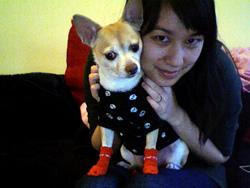

In [3]:
# Charger l'image comme matrice de pixels
img = Image.open('../data/Images/n02085620-Chihuahua/n02085620_7.jpg')
img

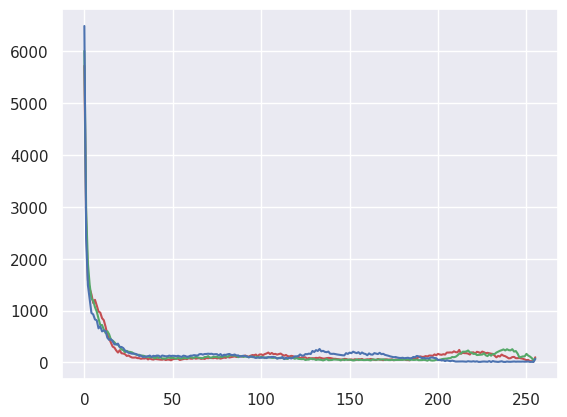

In [4]:
histogram_image(img)

#### 1.1.2 RECADRAGE.

Commençons par recadrer l'image sur la tête du chien :

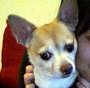

In [5]:
cropped_img = img.crop((65, 0, img.width - 95, img.height - 100))
cropped_img

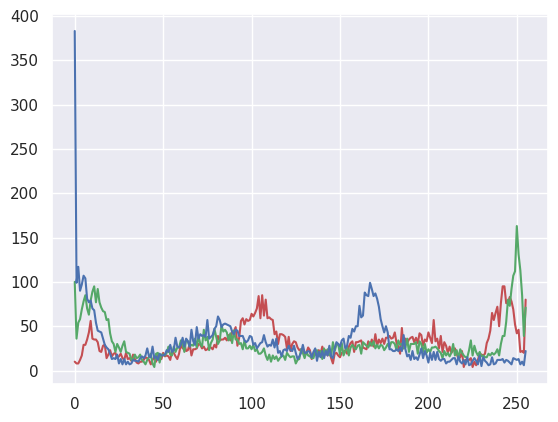

In [6]:
histogram_image(cropped_img)

In [7]:
cropped_mat = np.array(cropped_img)

#### 1.1.3 ÉTIREMENT DE L'HISTOGRAMME (WHITENING).

Nous allons maintenant étirer l'histogramme de l'image afin qu'il occupe toutes les plages de valeurs possibles (de 0 à 255). Ce traitement est inutile ici car l'histogramme est déjà étiré, mais nous le faisons simplement à titre d'illustration :

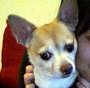

In [8]:
normalized_img = \
Image.fromarray((((cropped_mat - np.min(cropped_mat)) / (np.max(cropped_mat) - np.min(cropped_mat)))*255).astype(np.uint8))
normalized_img

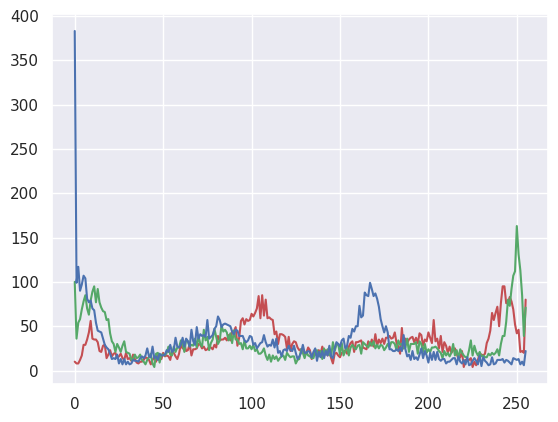

In [9]:
histogram_image(normalized_img)

On peut voir que l'histogramme n'a pas changé. 

Nous allons maintenant égaliser l'histogramme, c'est à dire faire en sorte que chaque intensité de couleur soit équitablement représentée (uniformisation des distributions des intensités). Cela permet d'améliorer le contraste de l'image.

#### 1.1.4 ÉGALISATION.

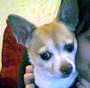

In [10]:
equalized_img = ImageOps.equalize(normalized_img)
equalized_img

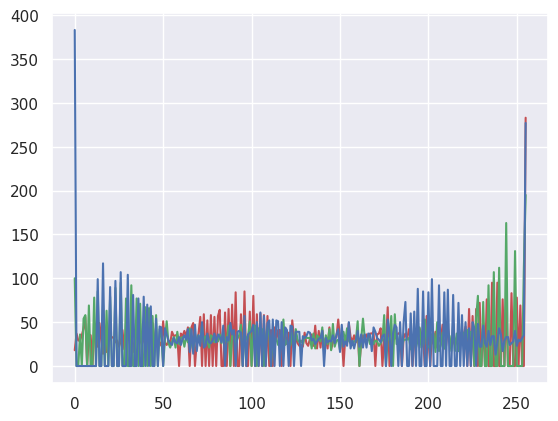

In [11]:
histogram_image(equalized_img)

#### 1.1.5 DÉBRUITAGE (AVEC FILTRE MÉDIAN).

Nous allons maintenant appliqué un filtre médian afin de débruiter l'image, même si cette image est déjà peu bruitée. Cette technique consiste à remplacer chaque pixel de l'image par la médiane des pixels voisins. L'intérêt d'un tel filtre est qu'il permet de débruiter l'image sans trop la flouter.

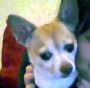

In [12]:
denoised_img = equalized_img.filter(ImageFilter.MedianFilter(size=3))
denoised_img

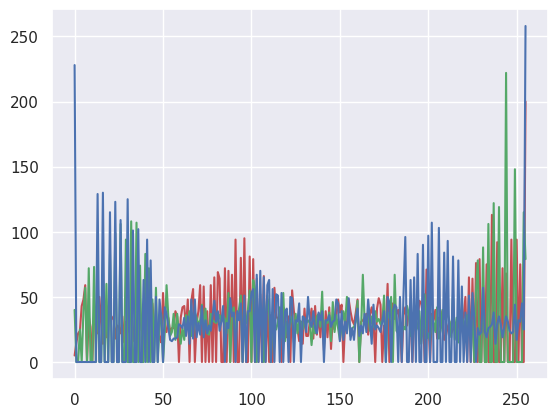

In [13]:
histogram_image(denoised_img)

#### 1.1.6 REDIMENSIONNEMENT.

Nous allons redimensionner l'image en taille 400*400 pixels :

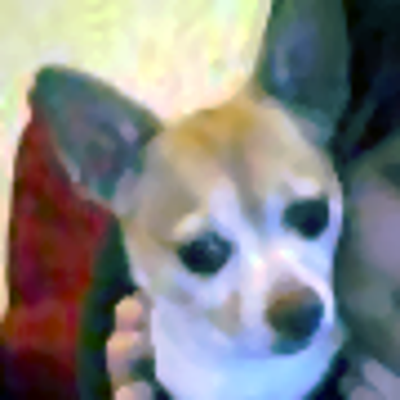

In [14]:
resized_img = denoised_img.resize((400, 400))
resized_img

On peut voir que l'image est floue, car en agrandissant l'image, il a fallu créer de nouveaux pixels à partir des pixels déja existants.

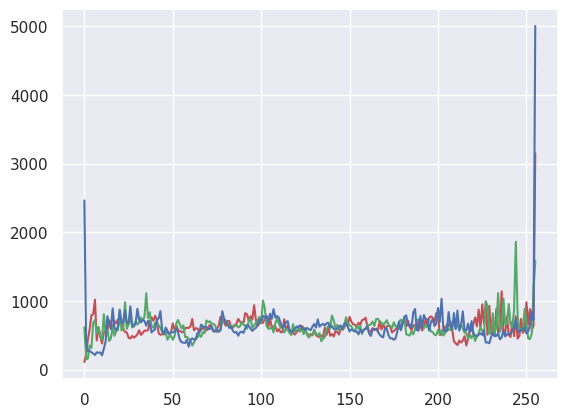

In [15]:
histogram_image(resized_img)

#### 1.1.7 MIRRORING.

Nous allons maintenant appliqué à l'image une technique couramment utilisée pour la data augmentation : le mirroring. Cette technique consiste à "mettre en mirroir" l'image, c'est à dire a réaliser une symétrie de l'image selon un axe vertical :

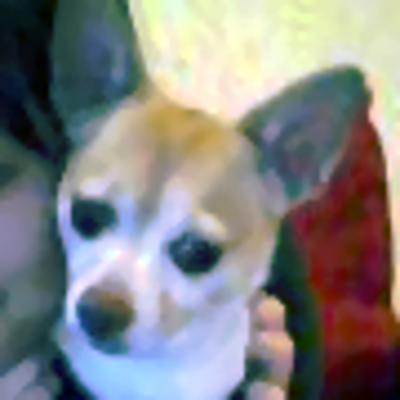

In [16]:
mirrored_img = ImageOps.mirror(resized_img)
mirrored_img

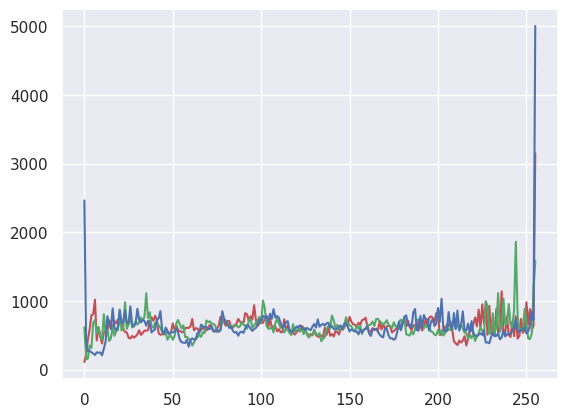

In [17]:
histogram_image(mirrored_img)

## 1.2 Sélection et préparation des données.

Nous allons créer trois dossiers :

- Un dossier **train** qui contiendra les données d'entraînement (64% des données) ;
- Un dossier **validation** qui contiendra les données de validation (16% des données) ;
- Un dossier **test** qui contiendra les données pour évaluer le modèle finalement choisi (20% des données).

In [18]:
# Chemin vers le dossier contenant toutes les images
base_dir = '../data/Images'
# Chemin vers les nouveaux dossiers 'train', 'validation' et 'test'
train_dir = '../data/train'
val_dir = '../data/validation'
test_dir = '../data/test'

Pour des raisons de contraintes en mémoire et temps de calcul, nous allons sélectionner aléatoirement trois classes de chiens parmi les 120 dont on dispose :

In [19]:
# Création des dossiers 'train', 'validation' et 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Sélection aléatoire de 3 classes
all_classes = os.listdir(base_dir)
selected_classes = random.sample(all_classes, 3)
print(f'Selected classes: {selected_classes}')

Selected classes: ['n02113978-Mexican_hairless', 'n02105855-Shetland_sheepdog', 'n02102480-Sussex_spaniel']


La fonction `copy_files` suivante permet de copier des fichiers d'un dossier à un autre. Elle prend en entrée trois arguments :

- ***fichiers*** : Liste des noms de fichiers à copier ;
- ***source*** : Nom du dossier d'origine ;
- ***destination*** : Nom du dossier de destination.

In [20]:
# Fonction pour copier les fichiers
def copy_files(fichiers, source, destination):
    for fichier in fichiers:
        fichier_source = os.path.join(source, fichier)
        fichier_destination = os.path.join(destination, fichier)
        shutil.copyfile(fichier_source, fichier_destination)

Le code ci-dessous sert à copier les fichiers situés dans les trois classes de chiens aléatoirement choisies précédemment vers les dossiers *train*, *validation* et *test* créer précédemment :

In [21]:
# Traitement de chaque classe sélectionnée
for class_name in selected_classes:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    
    # Diviser les images en train et test (80% train, 20% test)
    train, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Diviser les images de train en train et validation (80% train, 20% validation)
    train_images, val_images = train_test_split(train, test_size=0.2, random_state=42)
    
    # Création des sous-dossiers pour chaque classe
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    
    # Copier les images
    copy_files(train_images, class_dir, train_class_dir)
    copy_files(test_images, class_dir, test_class_dir)
    copy_files(val_images, class_dir, val_class_dir)